In [48]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Pyspark

In [49]:
!pip install pyspark

## Set up the environment for SparkSession and SparkContext

In [50]:
from pyspark import SparkContext

In [51]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("PySpark1").getOrCreate()

# Get the SparkContext from the SparkSession
sc = spark.sparkContext

In [52]:
# Spark version
sc.version

'3.5.0'

In [53]:
# PySpark version
sc.pythonVer

'3.10'

In [54]:
# Master location
sc.master

'local[*]'

Currently, the SparkSession is running in local (it can be either **Local** or Cluster)

#### Create a dataframe using CSV/JSON/TXT file

In [55]:
file_path = '/content/drive/My Drive/Research Data/Insect_PT.csv'
insect_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [56]:
insect_df.printSchema()

root
 |-- insectID: integer (nullable = true)
 |-- insect_name: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- crown: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- date_caught: string (nullable = true)
 |-- pole: string (nullable = true)



In [57]:
insect_df.take(6)

[Row(insectID=1, insect_name='nhen thay ma', price=30, crown=None, location='plaza', date_caught='10/17/2023 12:12', pole='DARK'),
 Row(insectID=2, insect_name='buom trang', price=68, crown=None, location='plaza', date_caught='10/17/2023 12:12', pole='DARK'),
 Row(insectID=3, insect_name='hop tien sao', price=100, crown=None, location='camp', date_caught='10/17/2023 14:42', pole='DARK'),
 Row(insectID=4, insect_name='bo hung thay ma', price=62, crown=None, location='camp', date_caught='10/17/2023 14:48', pole='DARK'),
 Row(insectID=5, insect_name='ran', price=20, crown=None, location='camp', date_caught='10/17/2023 14:48', pole='DARK'),
 Row(insectID=6, insect_name='buom vang', price=51, crown=1, location='camp', date_caught='10/17/2023 14:49', pole='DARK')]

## Machine Learning with MLlib

### Import MLLib

#### Collaborative Filtering

In [58]:
# Collaborative filtering: recommendation
from pyspark.mllib.recommendation import ALS

#### Rating class

In [59]:
from pyspark.mllib.recommendation import Rating
r = Rating(user = 1, product = 2, rating = 5.0)
p = Rating(user = 3, product = 10, rating = 8.8)

print((r[0], r[1], r[2]))
print((p[0], p[1], p[2]))

(1, 2, 5.0)
(3, 10, 8.8)


#### randomSplit()

In [60]:
data = sc.parallelize([1,2,3,4,5,6,7,8,9,10])
training, test = data.randomSplit([0.6, 0.4])

In [61]:
training.collect()

[1, 2, 4, 5, 6, 7]

In [62]:
test.collect()

[3, 8, 9, 10]

#### Classification

##### 1 Logistic Regression

In [63]:
# Classification
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

In [64]:
# Dense Vector
from pyspark.ml.linalg import Vectors
denseVec = Vectors.dense([1.0,2.0,3.0])

In [65]:
# Sparse Vector
sparseVec = Vectors.sparse(4, {1: 1.0, 3: 5.5})

In [66]:
# LabeledPoint() - Label for each class
from pyspark.mllib.regression import LabeledPoint
positive = LabeledPoint(1.0, [1.0, 0.0, 3.0])
negative = LabeledPoint(0.0, [2.0, 1.0, 1.0])
print(positive)
print(negative)

(1.0,[1.0,0.0,3.0])
(0.0,[2.0,1.0,1.0])


In [67]:
# # HashingTF
# from pyspark.ml.feature import HashingTF

# sentence = "hello hello world"
# words = sentence.split()
# tf = HashingTF(10000)
# tf.transform(words)

In [68]:
# Apply Logistic Regression
data = [
    LabeledPoint(0.0, [0.0, 1.0]),
    LabeledPoint(1.0, [1.0, 0.0])
]
rddlog = sc.parallelize(data)

In [69]:
# Train Model
lrm = LogisticRegressionWithLBFGS.train(rddlog)

In [70]:
lrm.predict([1.0, 1.0])

1

In [71]:
lrm.predict([0.0, 1.0])

0

#### Clustering

In [72]:
# Clustering
from pyspark.mllib.clustering import KMeans

In [73]:
# Train a K-Means clustering model
winedata = [(4.8, 12.7), (5.7, 16.2), (11.4, 8.2), (5.9, 15.5), (24.3, 0.3), (30.1, 0.1), (12.7, 9.7), (28.9, 0.2), (5.2, 15.9)]
RDD = sc.parallelize(winedata)
RDD.take(10)

model = KMeans.train(RDD, k=3, maxIterations = 10)
model.clusterCenters

[array([27.76666667,  0.2       ]),
 array([ 5.4  , 15.075]),
 array([12.05,  8.95])]

In [74]:
# Evaluate the K-means Model
from math import sqrt
def error(point):
  center = model.centers[model.predict(point)]
  return sqrt(sum([x**2 for x in (point - center)]))

In [75]:
WSSSE = RDD.map(lambda point: error(point)).reduce(lambda x, y: x+y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 14.040907538331608


In [76]:
# Visualizing Cluster
import pandas as pd
winedata = spark.createDataFrame(RDD, schema=["col1","col2"])
winepandas = winedata.toPandas()
cluster_center_pandas = pd.DataFrame(model.clusterCenters, columns=["col1","col2"])
cluster_center_pandas.head()

,col1,col2
0,27.766667,0.200
1,5.400000,15.075
2,12.050000,8.950


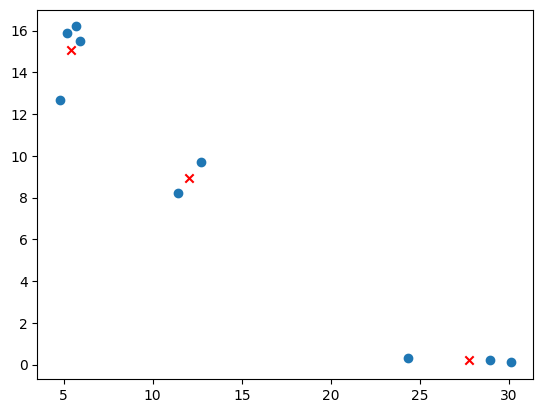

In [77]:
# MatPlotlib
import matplotlib.pyplot as plt
plt.scatter(winepandas['col1'], winepandas['col2'])
plt.scatter(cluster_center_pandas['col1'], cluster_center_pandas['col2'], color='red', marker='x')